## IMPORTING ALL THE REQUIRED LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import gensim
import os,sys
import matplotlib.pyplot as plt
import shutil
import re,string
import copy
!pip install pdfminer.six
from pdfminer.high_level import extract_text # to extract text from pdf by blocks
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karangupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Pre-Processing

## Extracting the abstract part from research papers

### Reason: Why not PDF2 is because it is primarily used to manipulating PDF files whereas PDFMiner is used for extracting information from the file.

In [2]:
abstracts = [] # List to contain all extracted abstracts

for files in os.listdir('/Users/karangupta/Desktop/FINAL PROJECTS/Research-Paper-Clustering/Green Energy Dataset'):
  # Extract text from the current PDF file
  text = extract_text('/Users/karangupta/Desktop/FINAL PROJECTS/Research-Paper-Clustering/Green Energy Dataset/'+ files) # for extracting text from pdf #string
  text_by_lines =  text.split('\n') # Split the text into lines and store it in a list

  # Check if the text contains the heading 'abstract' or its variations
  if ('abstract' in text.lower()) or ('a b s t r a c t' in text.lower()):
    start = 0
    end = 1
    
    # Find the line where 'abstract' starts
    for i, line in enumerate(text_by_lines):
      if ('a b s t r a c t' in line.lower()) or ('abstract' in line.lower()):
        start = i
        break
        
    # Find the line where the 'introduction' or its variations start
    for i, line in enumerate(text_by_lines[start:]):
      if ('introduction' in line.lower()) or ('content' in line.lower()) or ('c o n t e n t' in line.lower()) or ('i n t r o d u c t i o n' in line.lower()):
        end = start + i
        break
    
    # Check if the extracted abstract has more than 50 words and add it to the abstracts list
    if len((" ".join(text_by_lines[start:end])).split())> 50:
      abstracts.append(" ".join(text_by_lines[start:end]))
    
    else:
      # If the extracted abstract is too short, try to extract a longer paragraph
      counter = 0
      abstract = []
      for i in text_by_lines: # iterating through each line
        if i != '':
          counter +=1
          abstract.append(i)
        if i == '':
          if counter <8:
            abstract.clear()
            counter = 0
          elif counter >= 8:
            if len((' '.join(abstract)).split())>50:
              break
            else:
              abstract.clear()
              counter = 0
      abstracts.append(' '.join(abstract))


  else: # If no 'abstract' heading is found, take the first paragraph as the abstract
    counter = 0
    abstract = []
    for i in text_by_lines: # iterating through each line
      if i != '':
        counter +=1
        abstract.append(i)
      if i == '':
        if counter <8:
          abstract.clear()
          counter = 0
        elif counter >= 8:
          if len((' '.join(abstract)).split())>50:
            break
          else:
            abstract.clear()
            counter = 0
    abstracts.append(' '.join(abstract))


In [3]:
all_abstracts = copy.deepcopy(abstracts)

# 2. Text Vectorisation

## Creating Dataset using TF-IDF vectoriser

### Reason:  Word Embedding requires hard coding, messy code and used for relationship. Whereas TF-IDF has better performace, less code, best for evaluating the importance of word in document also known as Retrieval and Mining.

In [4]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Get the list of stop words in English
stop_word = stopwords.words('english')

# Initialize the TF-IDF vectorizer and remove stop words
tfidf = TfidfVectorizer(stop_words= stop_word)

# Fit the TF-IDF model and transform the abstracts into TF-IDF features
tf_idf_dataset = tfidf.fit_transform(abstracts)

# Get the feature names (words) corresponding to the TF-IDF features
feature_names =  tfidf.get_feature_names_out()

# Print the TF-IDF dataset
print(tf_idf_dataset)

  (0, 5861)	0.06766884210770042
  (0, 1537)	0.051813919364008316
  (0, 6097)	0.057665499608128265
  (0, 3545)	0.049589251804070665
  (0, 4424)	0.06766884210770042
  (0, 5616)	0.051813919364008316
  (0, 3886)	0.061817261863580476
  (0, 5704)	0.039585909304498505
  (0, 3133)	0.0430663052721944
  (0, 5632)	0.027211382528502283
  (0, 3880)	0.06766884210770042
  (0, 2450)	0.049589251804070665
  (0, 1494)	0.054445142614735216
  (0, 4181)	0.06766884210770042
  (0, 5562)	0.06766884210770042
  (0, 2150)	0.051813919364008316
  (0, 6067)	0.057665499608128265
  (0, 4970)	0.029582566804926342
  (0, 3054)	0.06766884210770042
  (0, 2463)	0.06766884210770042
  (0, 2583)	0.04065541870768697
  (0, 3846)	0.06766884210770042
  (0, 5630)	0.025955654120744038
  (0, 2078)	0.11533099921625653
  (0, 4226)	0.13533768421540085
  :	:
  (78, 3399)	0.007985030249086195
  (78, 1491)	0.013719435812419379
  (78, 2149)	0.015511261709455364
  (78, 3956)	0.02200111779586841
  (78, 2918)	0.023821283568847627
  (78, 1870)	

# 3. Clustering

## Using Elbow Method to know the optimal no. of clusters.

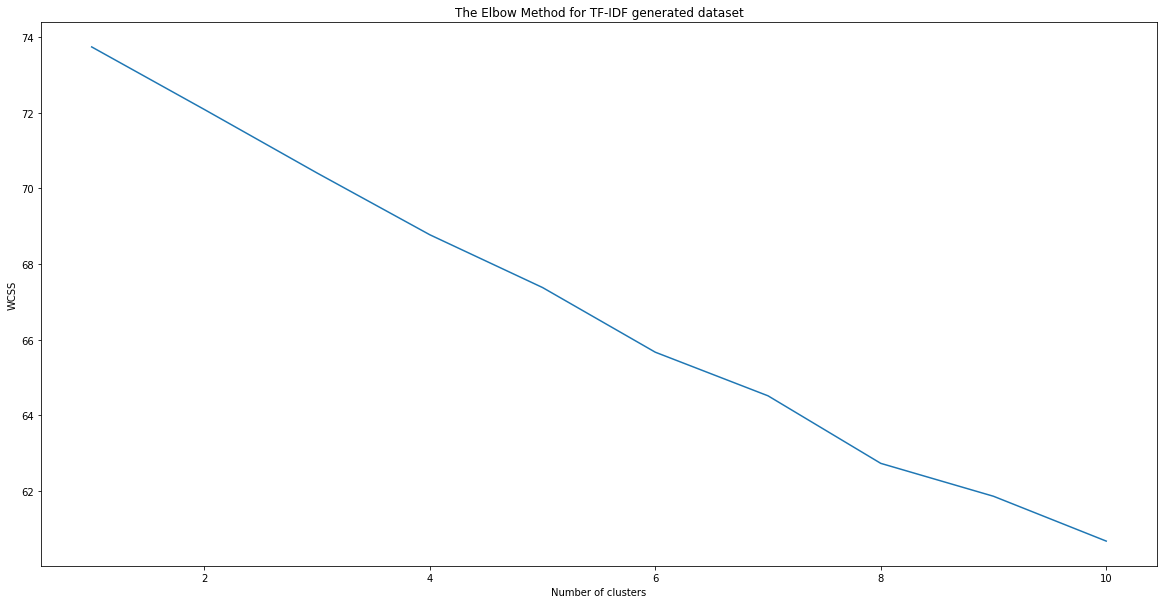

In [5]:
# Initialize an empty list to store WCSS (Within-Cluster Sum of Squares) values
wcss = []

# Running K-means for K values from 1 to 10
for i in range(1, 11):
    
    # Initialize KMeans with the current number of clusters (i)
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    # Fit the KMeans model to the TF-IDF dataset
    kmeans.fit(tf_idf_dataset)
    
    # Append the inertia (WCSS) of the current KMeans model to the list
    wcss.append(kmeans.inertia_)

# Ploting the WCSS values against the number of clusters
plt.figure(figsize=(20, 10)) # Set the figure size
plt.plot(range(1, 11), wcss) # Plot the WCSS values
plt.title('The Elbow Method for TF-IDF generated dataset') # Set the plot title
plt.xlabel('Number of clusters') # Label the x-axis
plt.ylabel('WCSS') # Label the y-axis
plt.show() # Display the plot

## Using Sihouette Analysis to know the optimal no. of clusters.

For n_clusters = 2, the average silhouette score is: 0.01728897440703974
For n_clusters = 3, the average silhouette score is: 0.014670628747112145
For n_clusters = 4, the average silhouette score is: 0.015511868601327061
For n_clusters = 5, the average silhouette score is: 0.02351205877243785
For n_clusters = 6, the average silhouette score is: 0.016590783008104133
For n_clusters = 7, the average silhouette score is: 0.02090257848386697
For n_clusters = 8, the average silhouette score is: 0.019481397585790674


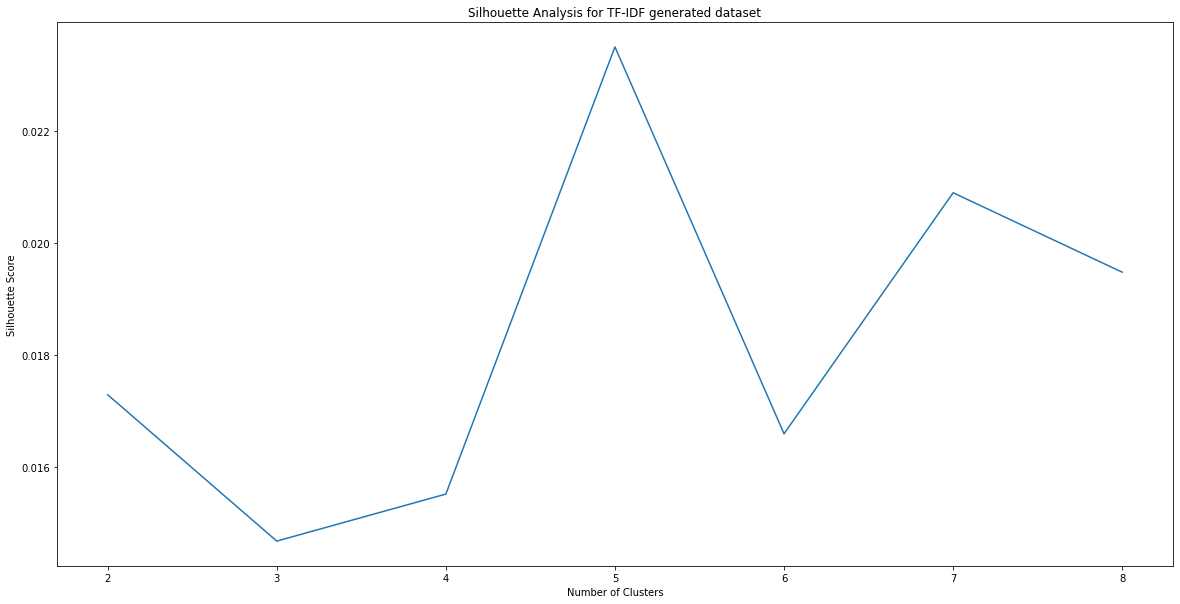

In [6]:
# Load your TF-IDF dataset into variable X
X = tf_idf_dataset

# Run K-Means for different number of clusters, or Defining a range of number of clusters to test
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Initialize a list to store silhouette scores for each number of clusters
silhouette_scores = []

# Run K-Means clustering for each number of clusters in the specified range
for n_clusters in range_n_clusters:
    
    # Initialize the KMeans model with the current number of clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    # Fit the model to the data and predict cluster labels
    cluster_labels = clusterer.fit_predict(X)
    
    # Calculate the average silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)
    
    # Print the silhouette score for the current number of clusters
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")

# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(20, 10)) # Set the figure size
plt.plot(range_n_clusters, silhouette_scores) # Plot the silhouette scores
plt.xlabel("Number of Clusters") # Label the x-axis
plt.ylabel("Silhouette Score") # Label the y-axis
plt.title("Silhouette Analysis for TF-IDF generated dataset") # Set the plot title
plt.show() # Display the plot

## Davies Bouldin Score

For n_clusters = 2, the average davies_bouldin_score is: 5.674277388664115
For n_clusters = 3, the average davies_bouldin_score is: 4.448862395580832
For n_clusters = 4, the average davies_bouldin_score is: 4.71556474279291
For n_clusters = 5, the average davies_bouldin_score is: 3.9944516800432552
For n_clusters = 6, the average davies_bouldin_score is: 4.0688036214497965
For n_clusters = 7, the average davies_bouldin_score is: 3.7888636078640983
For n_clusters = 8, the average davies_bouldin_score is: 3.5939562445818947


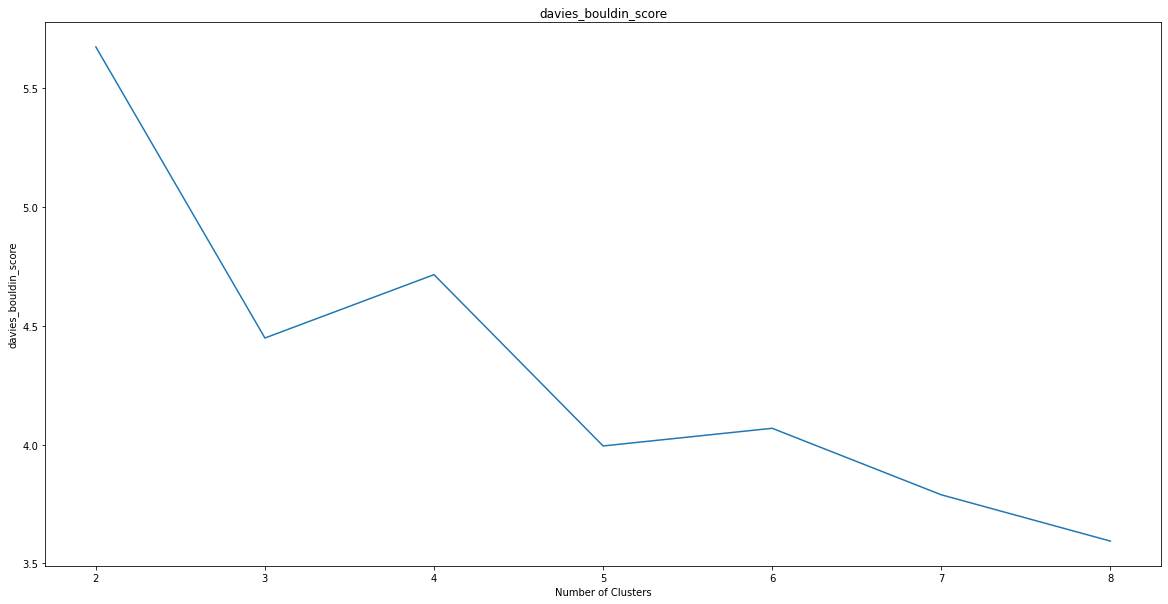

In [7]:
# for TF-IDF generated Dataset
# Load your data into X
X = tf_idf_dataset

# Run K-Means for different number of clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
davies_bouldin_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    X_dense = tf_idf_dataset.toarray()
    silhouette_avg = davies_bouldin_score(X_dense, cluster_labels)
    davies_bouldin_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average davies_bouldin_score is: {silhouette_avg}")

# Plot the davies_bouldin_score
plt.figure(figsize=(20, 10))
plt.plot(range_n_clusters, davies_bouldin_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("davies_bouldin_score")
plt.title("davies_bouldin_score")
plt.show()

## DBscan

In [8]:
X = tf_idf_dataset

# Apply DBSCAN clustering
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

# Create a mask for core samples
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Get the labels assigned by DBSCAN
labels = db.labels_

# Calculate the number of clusters, ignoring noise (-1)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 0
Estimated number of noise points: 79


## Reason: 

### 1. Going forward with K-Means Clustering because DBScan took everything into Noise Points, so it doesnt fit for our case.

### 2. Analysing the Graph of Elbow method and Silhouette analysis => I can see a very sharp peak at 5 for Silhouette analysis, plus I can see more significant increase and decrease whereas in Elbow I can't observe that behaviour so clearly.

### 3. Observing the Silhouette score and Davies-Bouldin index => I'm confident that Silhouette Score is evaluating the quality of cluserting result more appropriately since I can see a sudden increase and decrease in values at the point 5. Therefore, we are taking The Most Optimal Number of Cluster (K) as 5

# 4. Visualisation (Bonus)

## Taking optimal No. of clusters as 5 and proceeding with KMeans Classifier

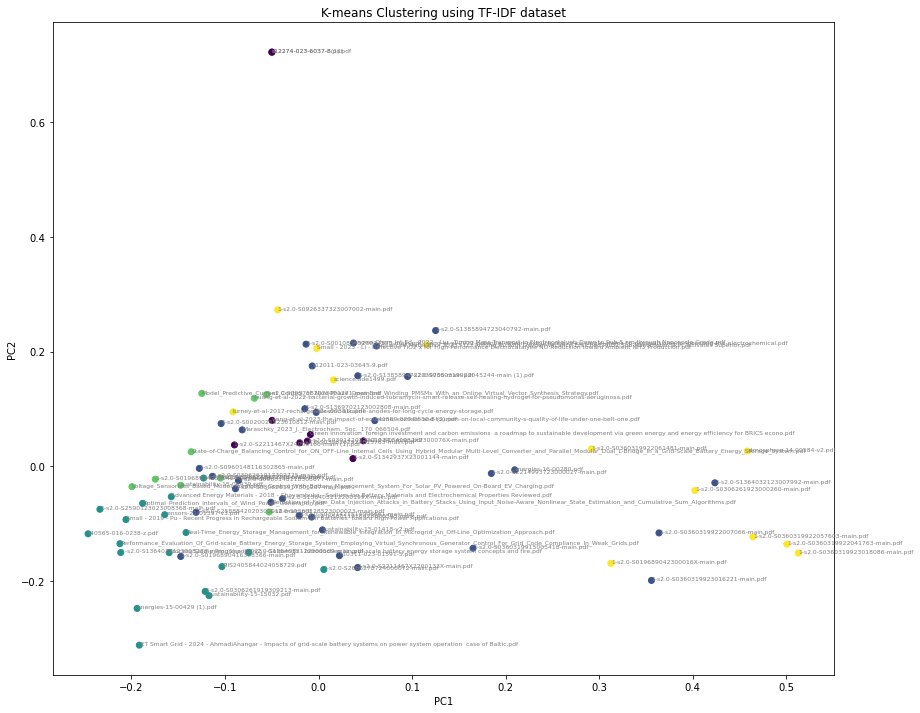

In [9]:
# taking optimal no. of clusters as 5 from both silhouette analysis and Elbow method for TF-IDF genereated dataset.
kmeans = KMeans(n_clusters=5, random_state=0).fit(tf_idf_dataset)
labels = kmeans.fit_predict(tf_idf_dataset)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_dense = tf_idf_dataset.toarray() # Convert sparse matrix to dense array
X_reduced = pca.fit_transform(X_dense) # Apply PCA to reduce dimensions to 2

# Plot the clustering results
plt.figure(figsize=(14, 12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering using TF-IDF dataset')

# Labeling datapoints with filenames
for i, title in enumerate(os.listdir('/Users/karangupta/Desktop/FINAL PROJECTS/Research-Paper-Clustering/Green Energy Dataset')):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], title, fontsize=6, color='#7f7f7f')
plt.show()

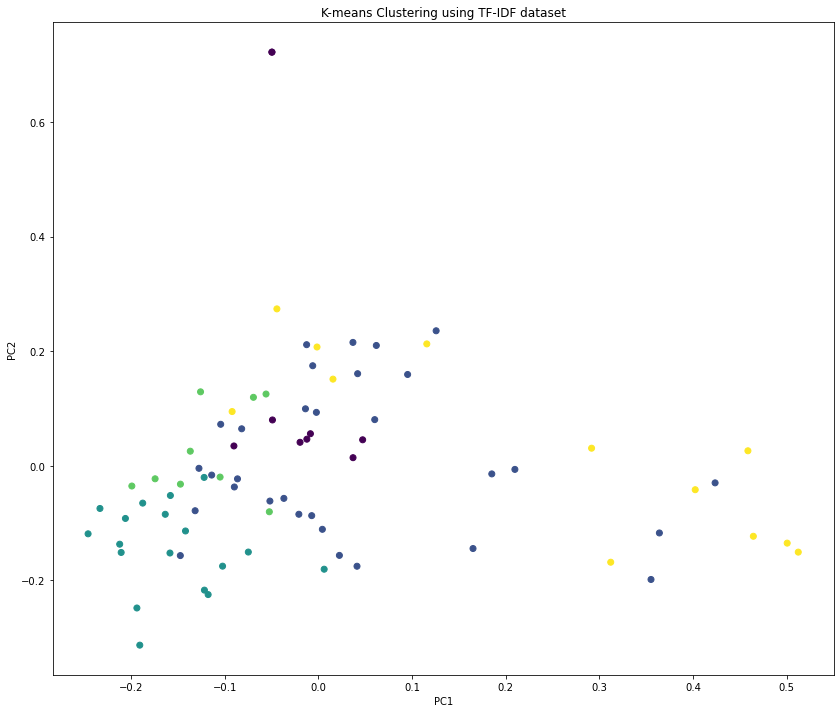

In [10]:
# taking optimal no. of clusters as 5 from both silhouette analysis and Elbow method for TF-IDF genereated dataset.
kmeans = KMeans(n_clusters=5, random_state=0).fit(tf_idf_dataset)
labels = kmeans.fit_predict(tf_idf_dataset)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_dense = tf_idf_dataset.toarray()
X_reduced = pca.fit_transform(X_dense)

# Plot the clustering results
plt.figure(figsize=(14, 12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering using TF-IDF dataset')

plt.show()

## Reason: 

### 1. Using PCA for reducing dimensionality since it's a computationally efficient manner, preserving the variance of the data, and handling large datasets. Whereas t-SNE is for visualizing and exploring the structure of high-dimensional data, particularly when the relationships between data points are nonlinear and complex.

### 2. Taking the Number of Component as 2 => Because we want to build a 2D Graph so that we can analyse the data points and classification done very easily.

# 5. Output Generation

## Based on The Graphs that are produced, the best one would be TF-IDF generated dataset and Through K Means clustering the optimal No. of clusters will be 5.

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(tf_idf_dataset)
labels = kmeans.fit_predict(tf_idf_dataset)

In [12]:
# There are 5 clusters so creating 5 different folders
num_folders = 5

# Create folders for each cluster
for folder_num in range(0, num_folders):
    folder_path = f"Folder{folder_num}"
    os.makedirs(folder_path, exist_ok=True)

# Assign each file to their respective folders based on cluster label
for i, file_name in enumerate(os.listdir('/Users/karangupta/Desktop/FINAL PROJECTS/Research-Paper-Clustering/Green Energy Dataset')):
    cluster_num = labels[i]
    folder_path = f"Folder{cluster_num}"
    src_file = '/Users/karangupta/Desktop/FINAL PROJECTS/Research-Paper-Clustering/Green Energy Dataset/'+ file_name
    dst_file = os.path.join(folder_path, file_name)
    shutil.copy(src_file, dst_file)

# Save the cluster assignment results to a CSV file
results_df = pd.DataFrame({ 'Paper': os.listdir('/Users/karangupta/Desktop/FINAL PROJECTS/Research-Paper-Clustering/Green Energy Dataset'), 'Cluster': labels})
results_df.to_csv('output_file.csv', index=False)

## Reason: 

### 1. Above code is saving the clustering results to a file called 'outpur_csv', indicating which papers belong to each cluster.

### 2. Also, below is a summary report that includes the number of clusters, the number of papers in each cluster, and the key terms or topics associated with each cluster.

In [13]:
from collections import Counter

# Count the number of PDFs in each cluster
number_of_pdf_in_each_cluster = dict(Counter(labels))

# Print the dictionary with the count of PDFs in each cluster
print(number_of_pdf_in_each_cluster)

{3: 9, 4: 12, 1: 31, 2: 18, 0: 9}


In [14]:
# Get cluster assignments from the K-means model
cluster_assignments = kmeans.labels_

# Get cluster centroids (centers)
cluster_centroids= kmeans.cluster_centers_

# Get feature names from TF-IDF vectorizer
feature_names= tfidf.get_feature_names_out()

# Iterate through each cluster
for cluster_id in range(5):
    
    # Get the centroid vector for the current cluster
    cluster_terms = cluster_centroids[cluster_id]
    
    # Get the indices of top 5 terms sorted by their importance in the centroid
    top_terms_indices= np.argsort(cluster_terms)[::-1][:5]
    
    # Get the actual top terms using their indices
    top_terms = [feature_names[I] for I in top_terms_indices]
    
    # Print cluster id and top terms
    print(f"cluster {cluster_id}: {','.join(top_terms)}")

    

cluster 0: environmental,development,cid,innovation,catalysts
cluster 1: hydrogen,energy,solar,wind,water
cluster 2: battery,energy,grid,storage,power
cluster 3: pv,solar,technique,shading,performance
cluster 4: ammonia,green,hydrogen,production,energy


## Summarising the entire Code Part:
This Code extracts the Abstract part from the research papers.

TF-IDF vectorization method was used to vectorize the Text from each abstract.

Clustering Methods like Kmeans and DBScan were used to make clusters and using Elbow method and silhouette analysis, it was determined that the optimal no. of clusters would be 5 and the model used in creating these clusters was KMeans classifier.

Then all the given research papers were classified based on the clustering labels and were distributed to seperate folders.

It has been verified manually that the classification technique used is correct and the research papers are classified properly.